### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
import graphviz
import xgboost as xgb
from xgboost import plot_importance
from sklearn.calibration import calibration_curve

### Load Data

In [2]:
cr_loan = pd.read_csv('cr_loan2.csv')
cr_loan.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
cr_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


### Exploratory Analysis

In [4]:
cr_loan.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [5]:
#distribution of loan status
cr_loan["loan_status"].value_counts()

0    25473
1     7108
Name: loan_status, dtype: int64

From this information, we see this is an imbalanced class problem. There are far more nondefalut cases than default cases.

In [6]:
pd.crosstab(cr_loan['loan_intent'], cr_loan['loan_status'])

loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,3722,1490
EDUCATION,5342,1111
HOMEIMPROVEMENT,2664,941
MEDICAL,4450,1621
PERSONAL,4423,1098
VENTURE,4872,847


In [7]:
pd.crosstab(cr_loan['person_home_ownership'], cr_loan['loan_status'],
              values=cr_loan['loan_percent_income'], aggfunc='mean')

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.146504,0.184882
OTHER,0.143784,0.300000
OWN,0.180013,0.297358
RENT,0.144611,0.264859


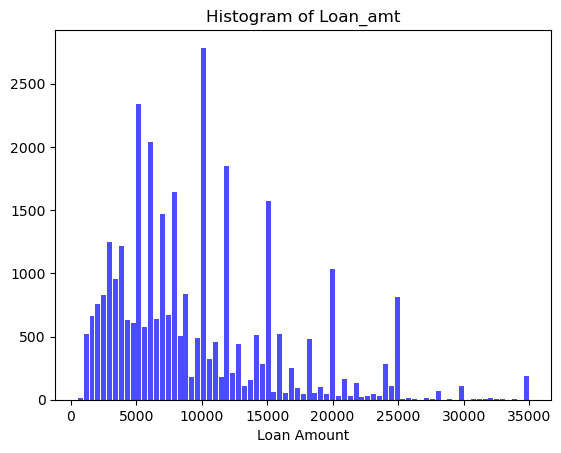

In [8]:
# Plot a histogram of loan_amnt
n, bins, patches = plt.hist(x=cr_loan['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.title("Histogram of Loan_amt")
plt.show()

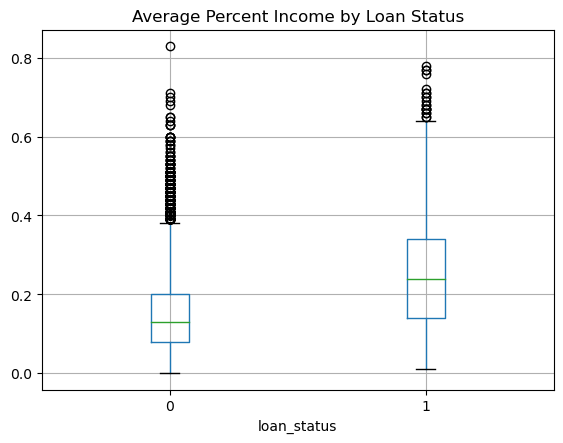

In [9]:
# box plot of percentage income by loan status
cr_loan.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

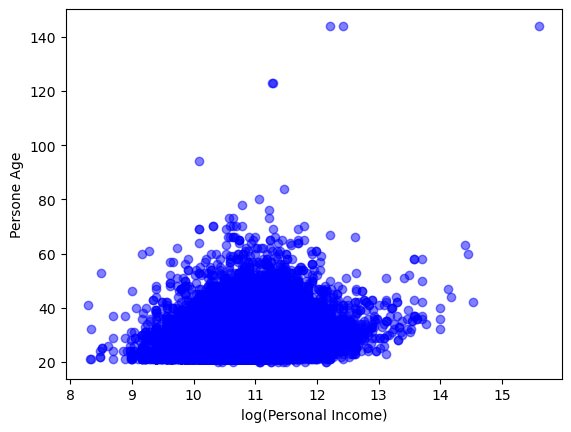

In [10]:
#relationship between income and age
plt.scatter(np.log(cr_loan['person_income']), cr_loan['person_age'],c='blue', alpha=0.5)
plt.xlabel('log(Personal Income)')
plt.ylabel('Persone Age')
plt.show()

<AxesSubplot:>

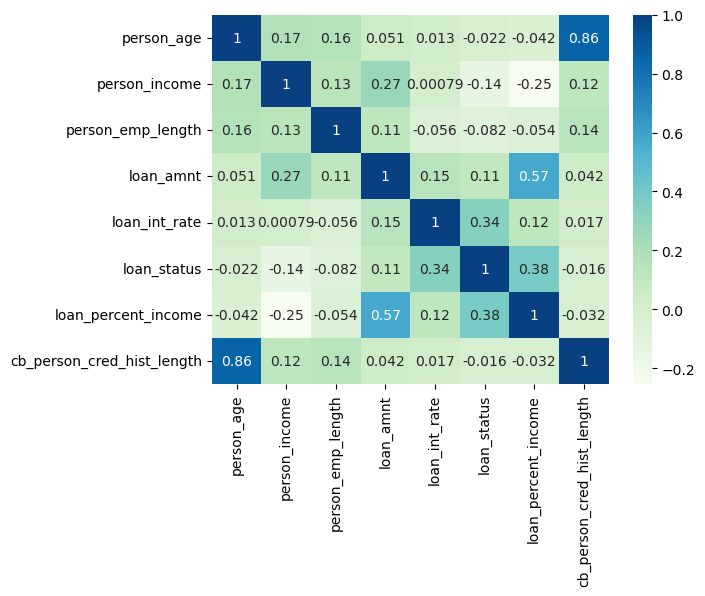

In [11]:
sns.heatmap(cr_loan.corr(),annot=True,cmap='GnBu')

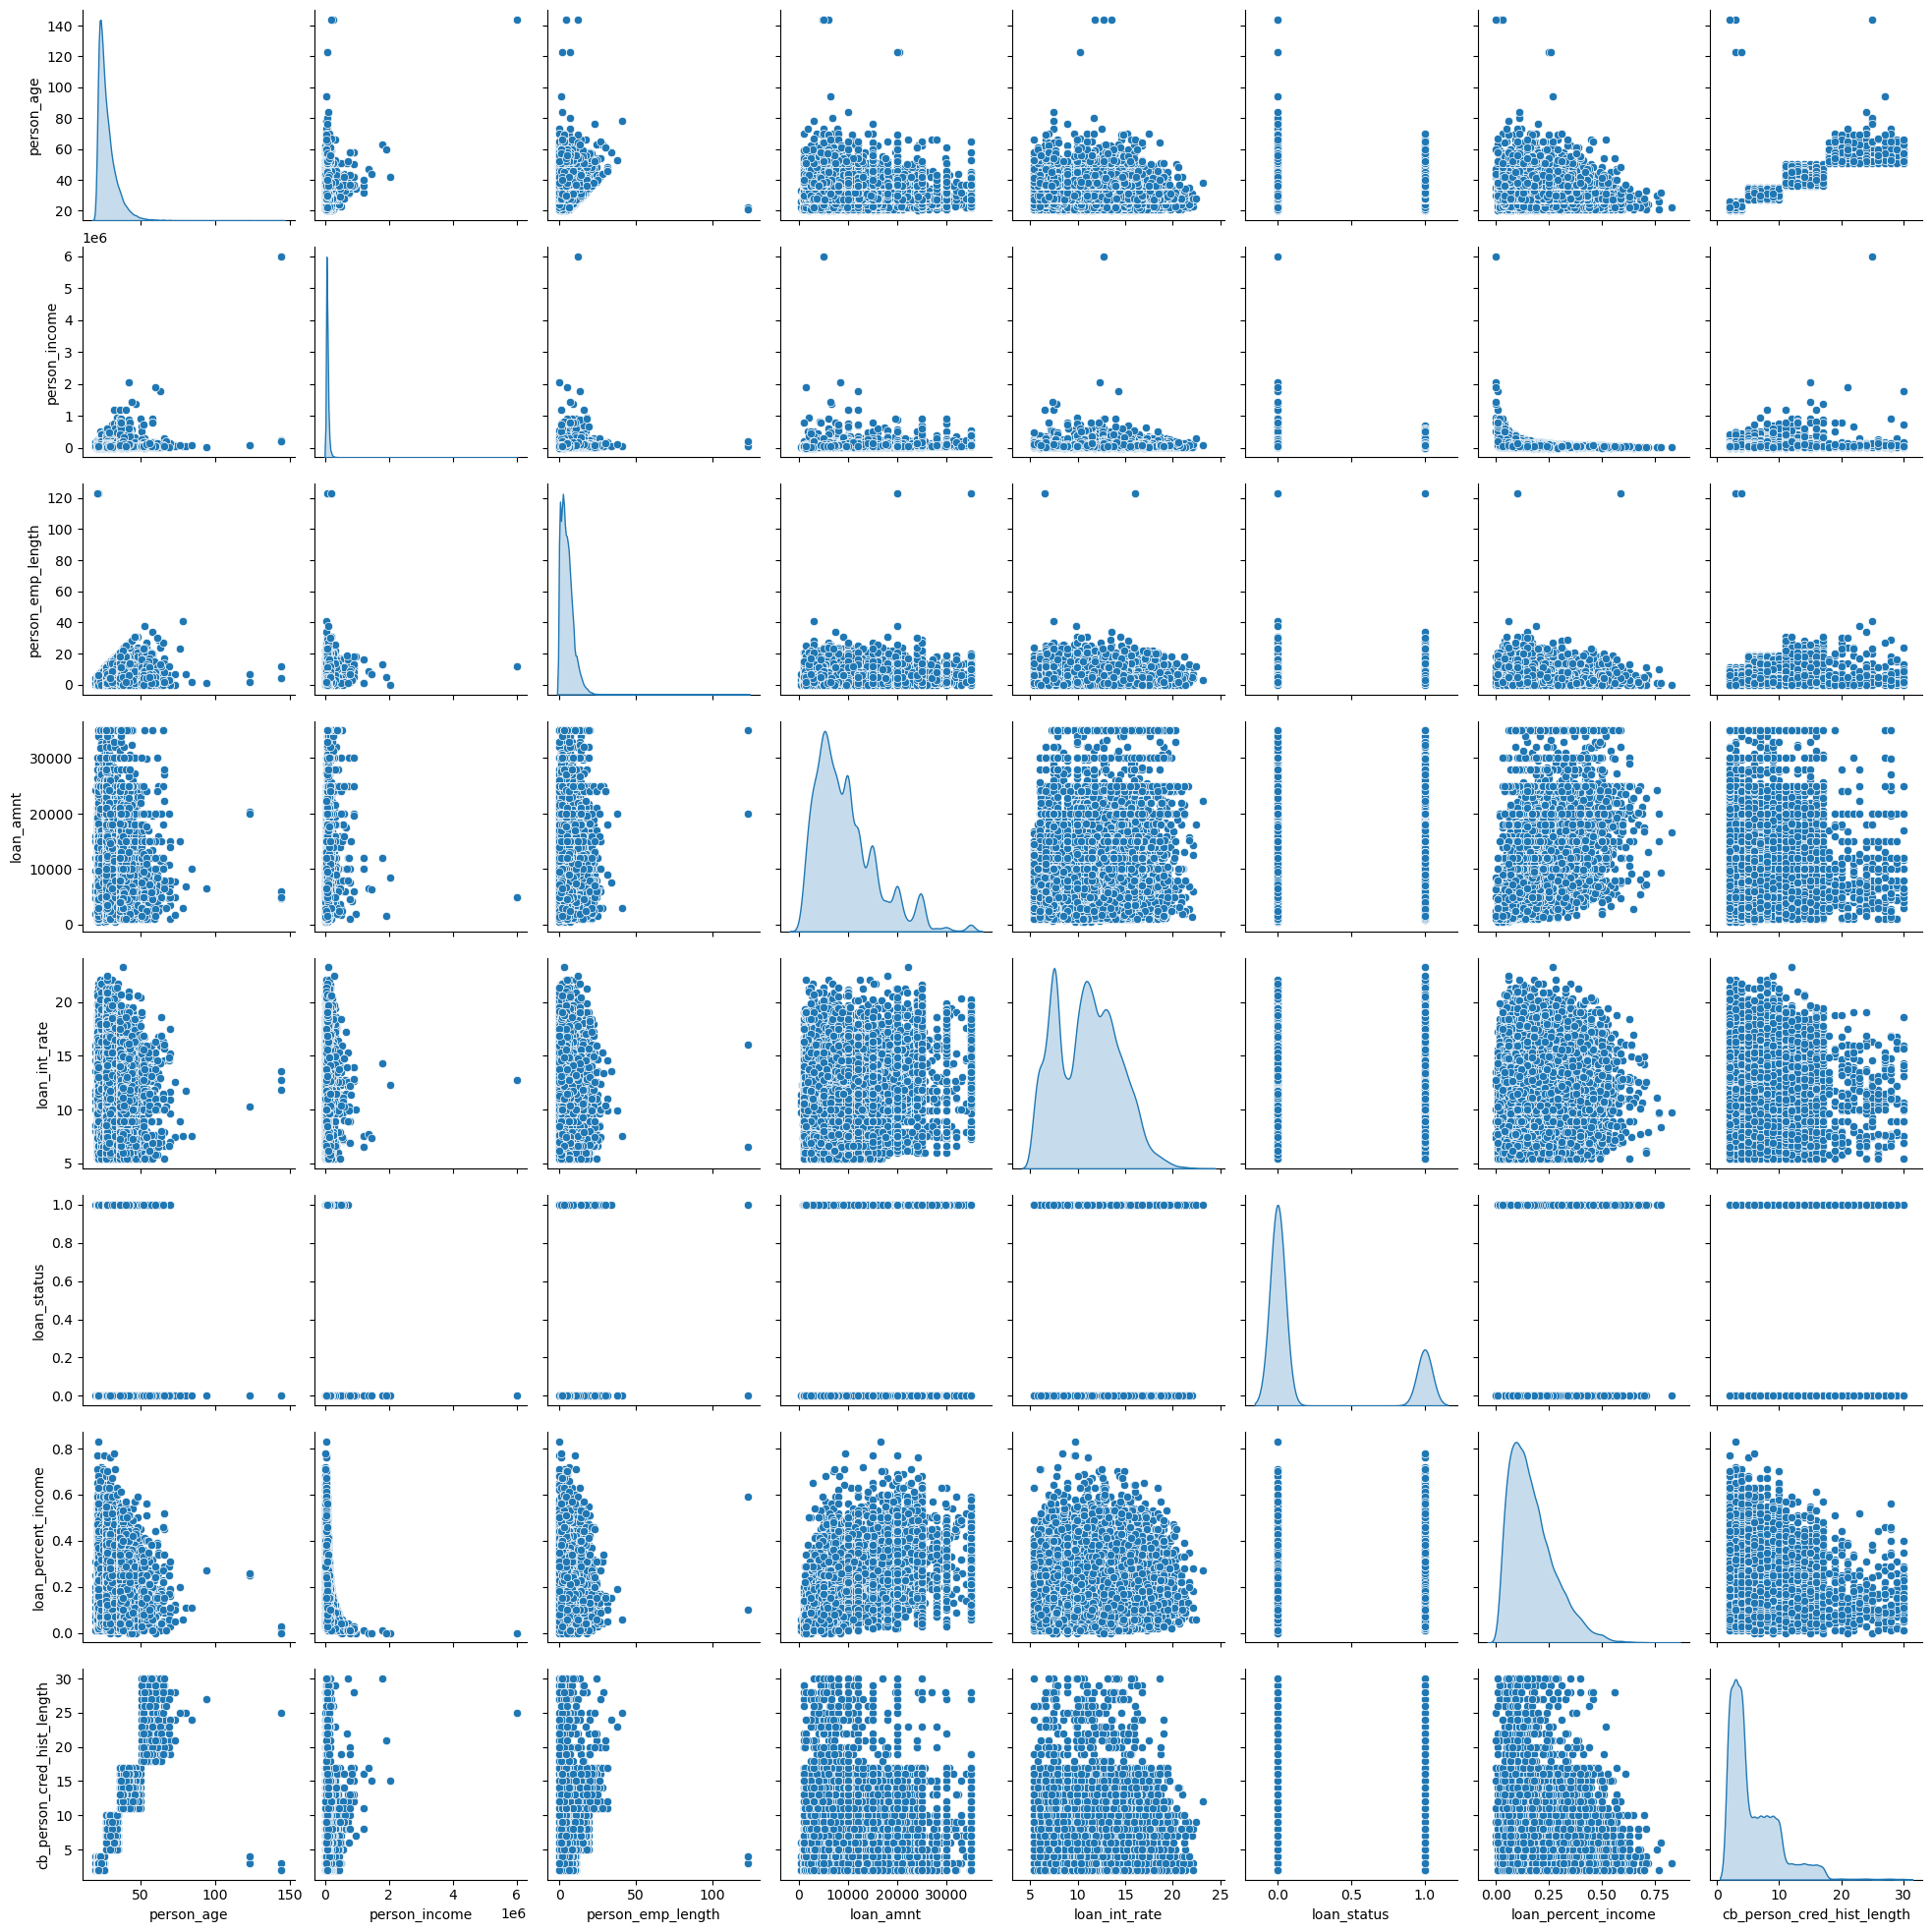

In [12]:
sns.pairplot(cr_loan,diag_kind = 'kde')
plt.show()

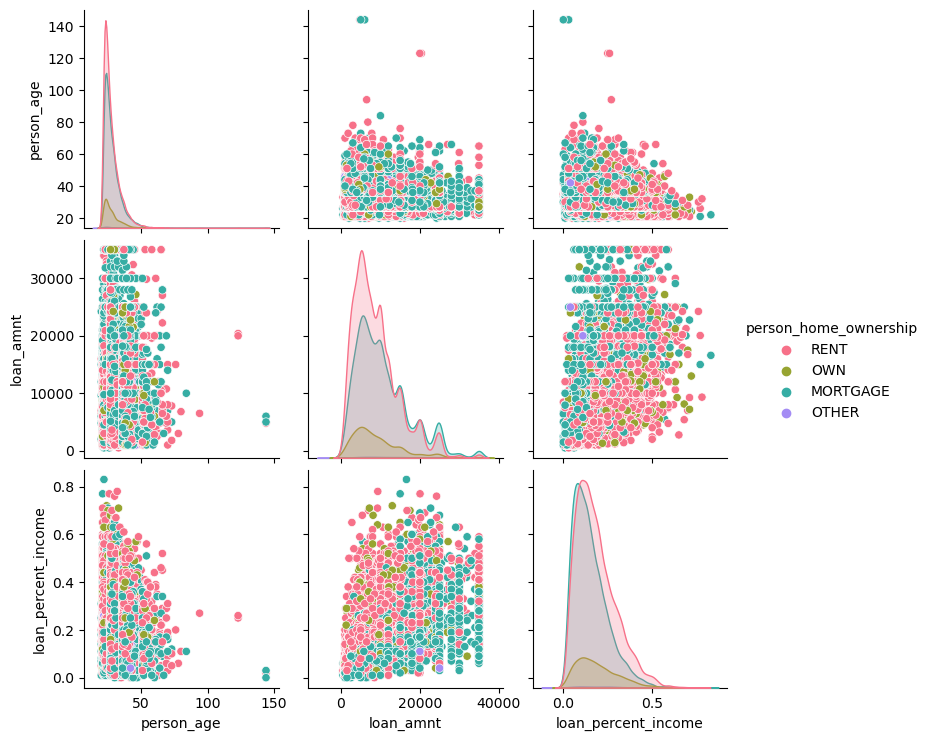

In [13]:
sns.pairplot(cr_loan, vars = ['person_age','loan_amnt','loan_percent_income'],
            hue = 'person_home_ownership', palette = 'husl')
plt.show()

### Data Processing

In [14]:
# outliers
# drop records where employment length is greater than 60 and age is greater than 100
indices = cr_loan[(cr_loan['person_emp_length'] > 60) | (cr_loan['person_age'] > 100)].index
cr_loan_new = cr_loan.drop(indices)
print(len(cr_loan) - len(cr_loan_new))

7


delete 7 records from the dataset

In [15]:
# missing values
null_columns = cr_loan_new.columns[cr_loan_new.isnull().any()]
cr_loan_new[null_columns].isnull().sum()

person_emp_length     895
loan_int_rate        3115
dtype: int64

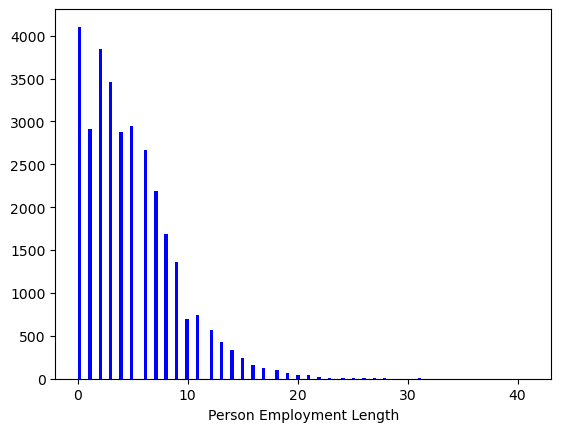

In [16]:
# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan_new['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

In [17]:
# Impute the null values with the median value for all employment lengths
cr_loan_new['person_emp_length'].fillna((cr_loan_new['person_emp_length'].median()), inplace=True)
# drop null records for loan interest rate
indices = cr_loan_new[cr_loan_new['loan_int_rate'].isnull()].index
cr_loan_clean = cr_loan_new.drop(indices)
len(cr_loan_clean)

29459

Now, we have 29459 records in total

In [18]:
# deal with categorical data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
# Separate non-numeric columns
cred_cat = cr_loan_clean.select_dtypes(include=['object'])
# One-hot encode the non-numeric columns only
cred_cat_onehot = pd.get_dummies(cred_cat,drop_first = True )
# Union the numeric columns with the one-hot encoded columns
cr_loan_clean2 = pd.concat([cred_num, cred_cat_onehot], axis=1)
cr_loan_clean2.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,1,...,0,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,1,0.57,3,0,0,...,1,0,0,0,1,0,0,0,0,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,1,0,0,0,1,0,0,0,0,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,1,0,0,0,1,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,1,...,0,0,1,0,0,0,0,0,0,0


In [19]:
# split the data into training set and test set
X = cr_loan_clean2.drop('loan_status',axis = 1)
y = cr_loan_clean2['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=321, stratify = y)
print('Training Features shape: ', X_train.shape)
print('Testing Features shape: ', X_test.shape)

Training Features shape:  (20621, 22)
Testing Features shape:  (8838, 22)


### logistic regression model

In [20]:
# build a logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs')
clf_logistic.fit(X_train,y_train)
print(clf_logistic.coef_)
# Make predictions
pred_train_y = clf_logistic.predict(X_train)
pred_test_y = clf_logistic.predict(X_test)
# accuracy
train_accuracy = accuracy_score(y_train, pred_train_y)
test_accuracy = accuracy_score(y_test, pred_test_y)
print('Training accuracy:', round(train_accuracy,4))
print('Test accuracy:', round(test_accuracy,4))

[[-6.14926825e-08 -4.01330483e-05 -2.62707250e-08  1.04969472e-04
   9.98117514e-08  2.53011084e-09 -9.92874653e-09  7.75250469e-11
  -4.19165460e-09  8.39076145e-09 -3.25542381e-09  1.54073628e-09
   1.61527051e-09 -1.26761584e-09 -3.91206572e-09 -5.90263585e-09
  -1.71283743e-09  1.15275495e-08  3.83894337e-09  9.99876190e-10
   4.81090202e-10  7.50552504e-09]]
Training accuracy: 0.8036
Test accuracy: 0.8033


In [21]:
train_precision= round(precision_score(y_train, pred_train_y),4)
test_precision = round(precision_score(y_test, pred_test_y),4)
train_recall= round(recall_score(y_train, pred_train_y),4)
test_recall = round(recall_score(y_test, pred_test_y),4)
print('Training precision: {}, Training recall: {}'.format(train_precision, train_recall))
print('Test precision: {}, Test recall: {}'.format(test_precision, test_recall))
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

Training precision: 0.7368, Training recall: 0.1634
Test precision: 0.7376, Test recall: 0.1609
              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      6899
     Default       0.74      0.16      0.26      1939

    accuracy                           0.80      8838
   macro avg       0.77      0.57      0.58      8838
weighted avg       0.79      0.80      0.75      8838



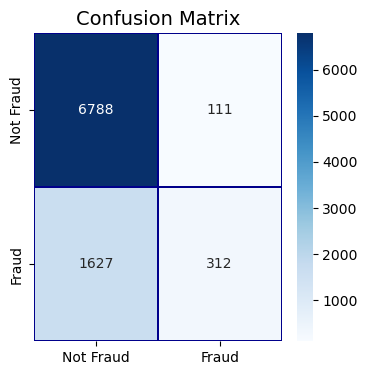

In [22]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

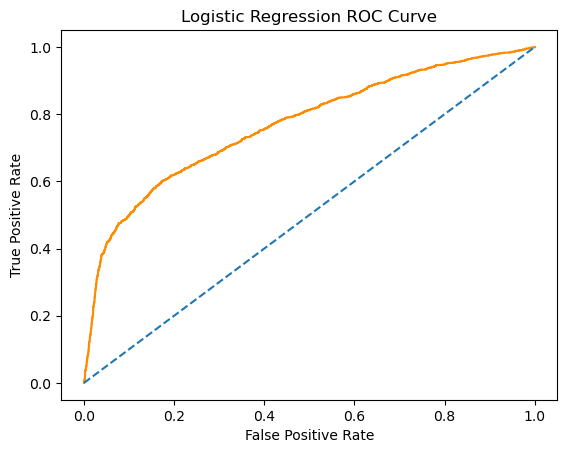

AUC =  0.7688


In [23]:
# ROC and AUC
y_pred_probs = clf_logistic.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()
auc = roc_auc_score(y_test, y_pred_probs)
print('AUC = ', round(auc,4))

The recall is relatively low which means this model had a poor performance on detecting default cases. But we do want predicting default users to avoid losses. To optimize this model, we gonna 1. standardize numerical data; 2. adjust the threshold

In [24]:
# scaling the data
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
num_cols = X_train.columns[:7]
cat_cols = X_train.columns[7:]
scaler = StandardScaler()
train_scaled_num = scaler.fit_transform(X_train[num_cols])
test_scaled_num = scaler.transform(X_test[num_cols])
print(np.mean(train_scaled_num), np.std(train_scaled_num))
train_scaled_num = pd.DataFrame(train_scaled_num, columns =num_cols )
test_scaled_num = pd.DataFrame(test_scaled_num, columns =num_cols )
X_train_scaled = pd.merge(train_scaled_num,X_train[cat_cols], how = 'left', left_index = True, right_index = True)
X_test_scaled = pd.merge(test_scaled_num,X_test[cat_cols], how = 'left', left_index = True, right_index = True)
X_train_scaled.head()

5.67067712938707e-17 0.9999999999999999


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,0.042799,-0.108101,1.810207,0.856838,-0.633835,0.747112,0.792963,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-0.762311,-0.579448,0.558126,0.856838,2.284638,2.432588,-0.943807,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,0.364843,2.531443,-1.194786,0.065789,-0.741471,-1.125640,0.296743,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.440267,0.457516,0.558126,-0.567050,-1.187391,-0.938365,-0.695697,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.203821,-0.202446,0.307710,-0.851827,1.521960,-0.844727,1.041073,0,0,1,...,0,1,0,0,0,0,1,0,0,1


In [25]:
# build a logistic regression model
clf_logistic_scaled = LogisticRegression(solver='lbfgs')
clf_logistic_scaled.fit(X_train_scaled,y_train)
# Make predictions
pred_train_y = clf_logistic_scaled.predict(X_train_scaled)
pred_test_y = clf_logistic_scaled.predict(X_test_scaled)
# accuracy
train_accuracy = accuracy_score(y_train, pred_train_y)
test_accuracy = accuracy_score(y_test, pred_test_y)
print('Training accuracy:', round(train_accuracy,4))
print('Test accuracy:', round(test_accuracy,4))
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

Training accuracy: 0.8667
Test accuracy: 0.8668
              precision    recall  f1-score   support

 Non-Default       0.88      0.95      0.92      6899
     Default       0.77      0.55      0.65      1939

    accuracy                           0.87      8838
   macro avg       0.83      0.75      0.78      8838
weighted avg       0.86      0.87      0.86      8838



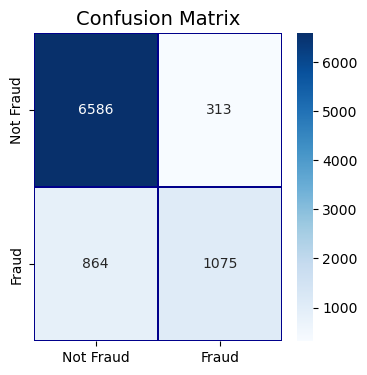

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

By standadizing the data, the overall accuracy and recall increase

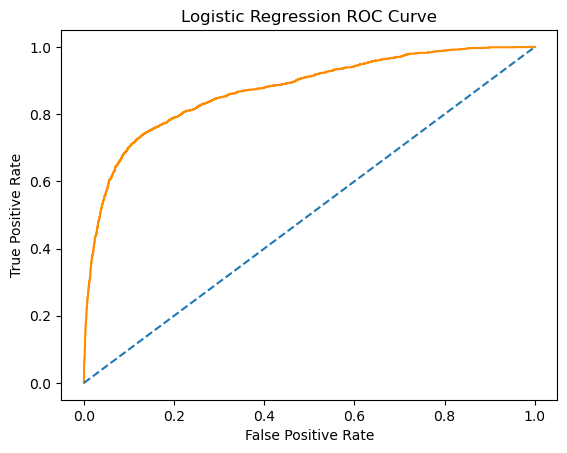

AUC =  0.8718


In [27]:
# ROC and AUC
y_pred_probs = clf_logistic_scaled.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()
auc = roc_auc_score(y_test, y_pred_probs)
print('AUC = ', round(auc,4))

D:\Program Files (x86)\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files (x86)\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


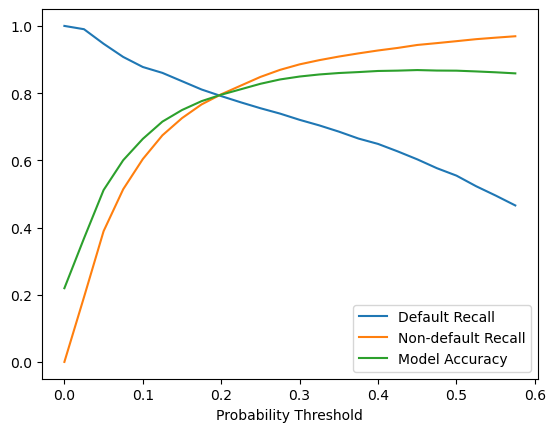

In [28]:
# threshould selection
thresh = np.arange(0,0.6,0.025)
pred_df = pd.DataFrame(y_pred_probs, columns = ['probs'])
def_recalls = []
nondef_recalls = []
accuracy = []

for i in thresh:
    pred_df['loan_status'] = pred_df['probs'].apply(lambda x:1 if x> i else 0)
    default_recall = precision_recall_fscore_support(y_test,pred_df['loan_status'])[1][1]
    def_recalls.append(default_recall)
    nondef_recall = precision_recall_fscore_support(y_test,pred_df['loan_status'])[1][0]
    nondef_recalls.append(nondef_recall)
    accu = accuracy_score(y_test, pred_df['loan_status'])
    accuracy.append(accu)
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accuracy)
plt.xlabel("Probability Threshold")
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.show()

There's trade-off between various metrics, from this graph, it's better to choose 0.2 as threshold. We got overall accuracy of 80%

In [29]:
pred_df['loan_status'] = pred_df['probs'].apply(lambda x:1 if x> 0.2 else 0)
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_df['loan_status'] , target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.80      0.86      6899
     Default       0.52      0.79      0.63      1939

    accuracy                           0.80      8838
   macro avg       0.73      0.79      0.74      8838
weighted avg       0.84      0.80      0.81      8838



### Decision Tree

In [30]:
# build a decision tree
tree = DecisionTreeClassifier()
tree.fit(X_train_scaled,y_train)
# Make predictions
pred_train_y = tree.predict(X_train_scaled)
pred_test_y = tree.predict(X_test_scaled)
# accuracy
train_accuracy = accuracy_score(y_train, pred_train_y)
test_accuracy = accuracy_score(y_test, pred_test_y)
print('Training accuracy:', round(train_accuracy,4))
print('Test accuracy:', round(test_accuracy,4))
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

Training accuracy: 1.0
Test accuracy: 0.8904
              precision    recall  f1-score   support

 Non-Default       0.93      0.92      0.93      6899
     Default       0.74      0.77      0.75      1939

    accuracy                           0.89      8838
   macro avg       0.84      0.85      0.84      8838
weighted avg       0.89      0.89      0.89      8838



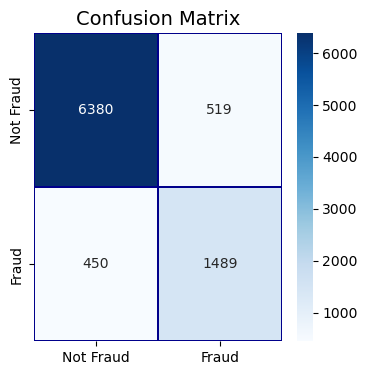

In [31]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [32]:
#AUC
roc_auc_score(y_test, pred_test_y)

0.846346657560599

In [33]:
# tree depth paramater tuning
depth_list = list(range(2,20))
depth_tuning = np.zeros((len(depth_list),4))
depth_tuning[:,0] = depth_list
for index in range(len(depth_list)):
    tree = DecisionTreeClassifier(max_depth =depth_list[index] )
    tree.fit(X_train_scaled,y_train)
    pred_test_y = tree.predict(X_test_scaled)
    depth_tuning[index,1] = accuracy_score(y_test,pred_test_y )
    depth_tuning[index,2] = precision_score(y_test,pred_test_y )
    depth_tuning[index,3] = recall_score(y_test,pred_test_y )
col_names = ['Max_Depth','Accuracy','Precision','Recall']
tree_result = pd.DataFrame(depth_tuning, columns =col_names )
tree_result

,Max_Depth,Accuracy,Precision,Recall
0,2.0,0.852003,0.670448,0.640021
1,3.0,0.878592,0.736354,0.695719
2,4.0,0.895112,0.881599,0.602888
3,5.0,0.909255,0.937644,0.628159
4,6.0,0.911632,0.940639,0.637442
5,7.0,0.911292,0.874271,0.695719
6,8.0,0.919552,0.907162,0.705518
7,9.0,0.923512,0.948190,0.689015
8,10.0,0.923512,0.932831,0.701908
9,11.0,0.924757,0.925802,0.714286


When max depth is 13, we hot highest accuracy, but it may be too complicated.

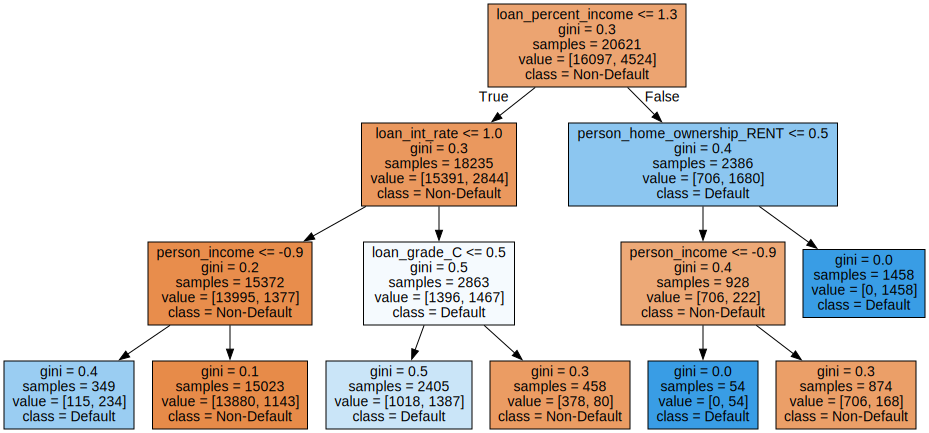

In [34]:
mytree = DecisionTreeClassifier(max_depth =3)
mytree.fit(X_train_scaled,y_train)
cols = X_train_scaled.columns
from sklearn import tree
# visualize the tree with 3 depth
exported = tree.export_graphviz(decision_tree = mytree,
                                    out_file = None,
                                    feature_names = cols,
                                    precision = 1,
                                    class_names = ['Non-Default', 'Default'],filled = True)
graph = graphviz.Source(exported)
display(graph)

### Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators = 100,
                           criterion = 'gini',
                           max_depth = 5,
                           bootstrap = True)
rf.fit(X_train_scaled,y_train)
pred_test_y = rf.predict(X_test_scaled)
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.90      0.99      0.94      6899
     Default       0.96      0.59      0.73      1939

    accuracy                           0.90      8838
   macro avg       0.93      0.79      0.84      8838
weighted avg       0.91      0.90      0.90      8838



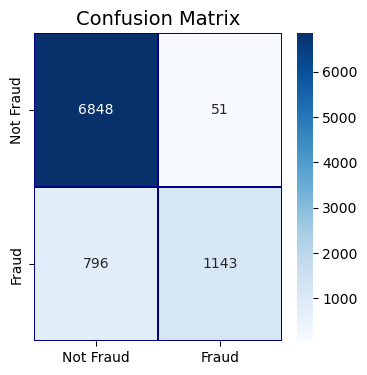

In [36]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [37]:
#AUC
roc_auc_score(y_test, pred_test_y)

0.7910433686190964

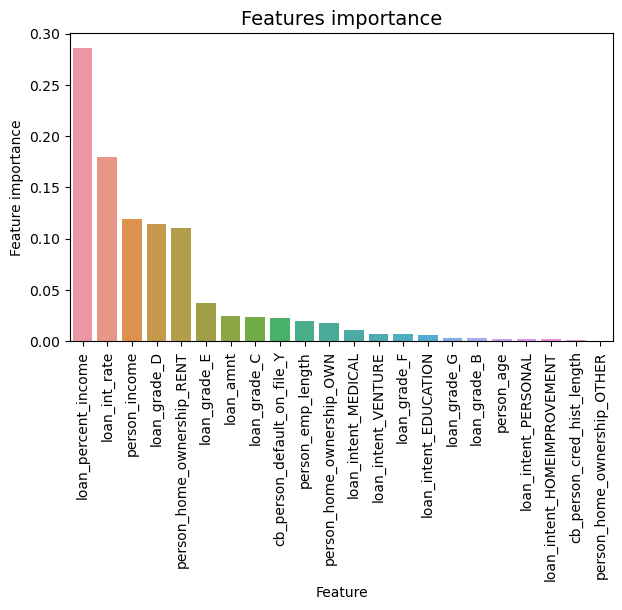

In [38]:
# feature importance
tmp = pd.DataFrame({'Feature': X_train_scaled.columns, 'Feature importance': rf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are loan_percent_income, interest_rate, and income.

### XGBoost

In [39]:
# build XGBoost model
clf_gbt = xgb.XGBClassifier(n_estimators = 100,
                           max_depth = 5)
clf_gbt.fit(X_train_scaled,y_train)
pred_test_y = clf_gbt.predict(X_test_scaled)
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      6899
     Default       0.95      0.74      0.83      1939

    accuracy                           0.93      8838
   macro avg       0.94      0.86      0.90      8838
weighted avg       0.94      0.93      0.93      8838



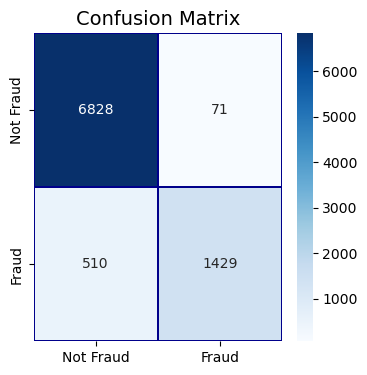

In [40]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [41]:
#AUC
roc_auc_score(y_test, pred_test_y)

0.863343238524228

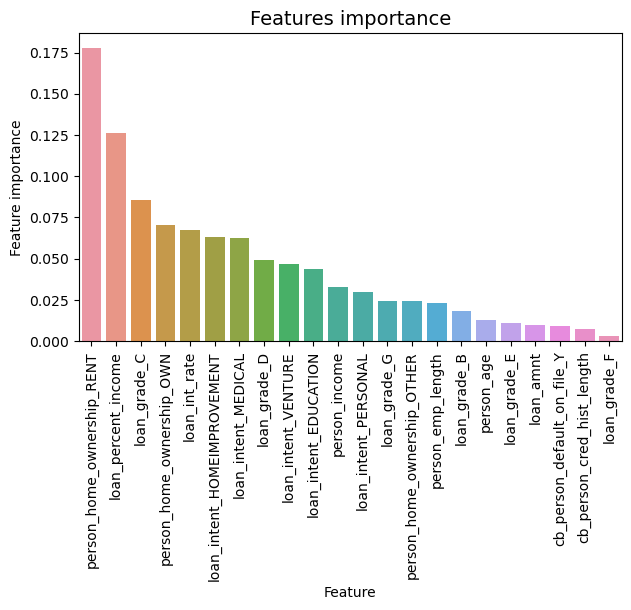

In [42]:
# feature importance
tmp = pd.DataFrame({'Feature': X_train_scaled.columns, 'Feature importance': clf_gbt.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

The most important features are different from features from random forest, they are rent, loan_percent_income, C grade
For now, XGBoost performs best with accuracy of 93% and recall of 93%. However, we noticed at the beginning that the dataset is imbalanced, so we want to try to resample the data and then build XGBoost models.

undersample the data

In [43]:

X_y_train = pd.concat([X_train_scaled.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]
# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)
X_train_under = X_y_train_under.drop(['loan_status'],axis = 1)
y_train_under = X_y_train_under['loan_status']
y_train_under.value_counts()

0    4524
1    4524
Name: loan_status, dtype: int64

Now, we have balanced data with 9048 records

In [44]:
# build XGBoost model
clf_gbt2 = xgb.XGBClassifier(n_estimators = 100,max_depth = 5)
clf_gbt2.fit( X_train_under, y_train_under)
kf = KFold(n_splits = 5, shuffle = True, random_state = 111)
print(cross_val_score(clf_gbt2, X_train_under, y_train_under, cv = kf))
pred_test_y = clf_gbt2.predict(X_test_scaled)
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

[0.85801105 0.86298343 0.87016575 0.87617468 0.86124931]
              precision    recall  f1-score   support

 Non-Default       0.95      0.90      0.92      6899
     Default       0.70      0.83      0.76      1939

    accuracy                           0.89      8838
   macro avg       0.83      0.87      0.84      8838
weighted avg       0.89      0.89      0.89      8838



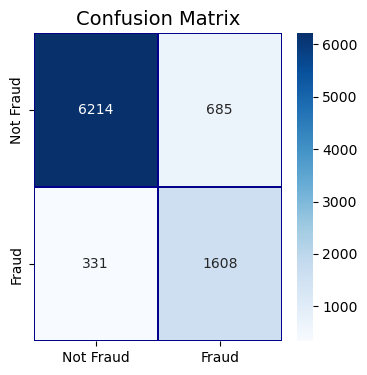

In [45]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [46]:
#AUC
roc_auc_score(y_test, pred_test_y)

0.8650018490470437

oversample method--SMOTE

In [47]:
print('The original training data size: \n',y_train.value_counts())
smote = SMOTE(random_state=321)
X_train_over, y_train_over = smote.fit_resample(X_train_scaled, y_train)
print('Oversampled training data size: \n',y_train_over.value_counts())

The original training data size: 
 0    16097
1     4524
Name: loan_status, dtype: int64
Oversampled training data size: 
 0    16097
1    16097
Name: loan_status, dtype: int64


In [48]:
# build XGBoost model
clf_gbt3 = xgb.XGBClassifier(n_estimators = 100, max_depth = 5)
clf_gbt3.fit( X_train_over, y_train_over)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
print(cross_val_score(clf_gbt3, X_train_over, y_train_over, cv = kf))
pred_test_y = clf_gbt3.predict(X_test_scaled)
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_test_y, target_names=target_names))

[0.95496195 0.95107936 0.95216649 0.95154527 0.95215906]
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      6899
     Default       0.94      0.74      0.83      1939

    accuracy                           0.93      8838
   macro avg       0.93      0.86      0.89      8838
weighted avg       0.93      0.93      0.93      8838



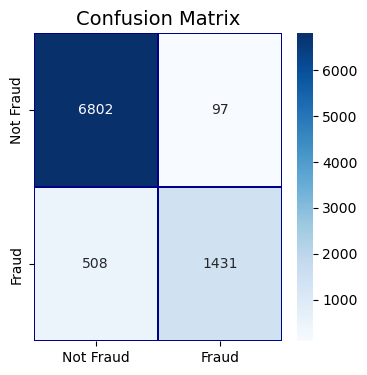

In [49]:
# confusion matrix
cm = confusion_matrix(y_test, pred_test_y)
fig, (ax1) = plt.subplots(ncols=1, figsize=(4,4))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,fmt='d',
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [50]:
#AUC
roc_auc_score(y_test, pred_test_y)

0.8619746372193622

Oversampling does not have an influencial impact on the performace of the model, while undersampling helps identify more default cases. By comparing all the models we built, we can find XGBoost performs best.

In [51]:
# create calibration curve
test_proba = clf_gbt.predict_proba(X_test_scaled)[:,1]
prob_true, prob_pred = calibration_curve(y_test.values, test_proba, n_bins =20)

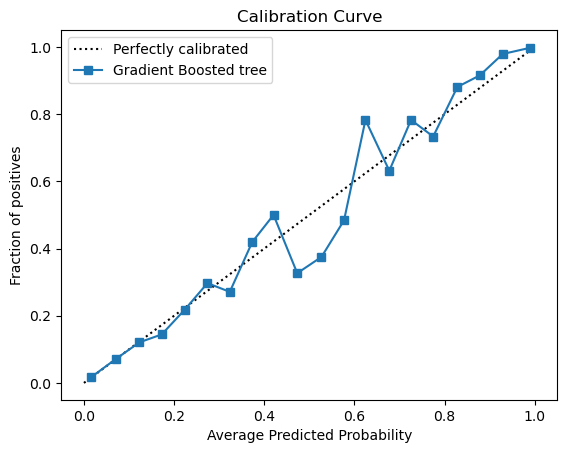

In [52]:
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.xlabel('Fraction of positives')
plt.ylabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.plot(prob_pred, prob_true,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

From the calibration curve, when model predictions are around 0.5, more of the loans are actually non-default. This is where the majority of the false positive exist, which may cause a loss of profit. But in general, the predicted probabilities are close enough to the percentage of true defaults, it shows the model has a stong predictive performance. 

### Credit strategy

Define acceptance rate as what percentage of new loans are accepted to keep the number of defaults in a portfolio low. We first set acceptance rate as 0.85. 

In [54]:
threshold_85 = np.quantile(test_proba, 0.85)
test_pred_df = pd.DataFrame(test_proba, columns = ['Prob'])
test_pred_df['pred_loan_status'] = test_pred_df['Prob'].apply(lambda x: 1 if x > threshold_85 else 0)
print(test_pred_df['pred_loan_status'].value_counts())

0    7512
1    1326
Name: pred_loan_status, dtype: int64


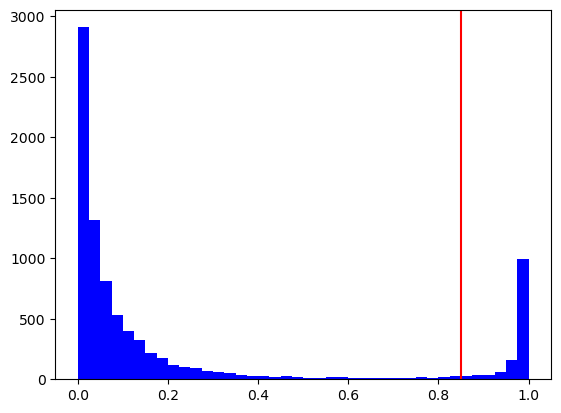

In [55]:
# Plot the predicted probabilities of default
plt.hist(test_proba, color = 'blue', bins = 40)
threshold = np.quantile(test_proba, 0.85)
# Add a reference line to the plot for the threshold
plt.axvline(x = 0.85, color = 'red')
plt.show()

bad rate = accepted defaults/ total accepted loans

In [56]:
test_pred_df['true_loan_status'] = y_test.values
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

0.08320021299254526


Sensitive test on different acceptance rate

In [57]:
accept_rates = np.arange(0.5,1,0.05)
bad_rates = []
thresholds = []
accept_ct = []
for rate in accept_rates:
    thresh = np.quantile(test_pred_df['Prob'], rate).round(3)
    thresholds.append(np.quantile(test_pred_df['Prob'], rate).round(3))
    test_pred_df['pred_loan_status'] = test_pred_df['Prob'].apply(lambda x: 1 if x > thresh else 0)
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))
    accept_ct.append(len(accepted_loans))
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates,accept_ct,),
                        columns = ['Acceptance Rate','Threshold','Bad Rate','Accept Count'])
strat_df

,Acceptance Rate,Threshold,Bad Rate,Accept Count
0,0.50,0.055,0.020,4409
1,0.55,0.069,0.023,4874
2,0.60,0.087,0.026,5311
3,0.65,0.110,0.033,5739
4,0.70,0.142,0.040,6184
5,0.75,0.190,0.047,6632
6,0.80,0.301,0.059,7071
7,0.85,0.832,0.083,7512
8,0.90,0.984,0.132,7946
9,0.95,0.996,0.177,8382


In [58]:
strat_df['Avg Loan Amnt'] = np.mean(X_test['loan_amnt'])
# estimated value is the estimated net value of non-defaults minus defaults
strat_df['Estimated Value'] = strat_df['Accept Count'] *(1-strat_df['Bad Rate'])*strat_df['Avg Loan Amnt'] - (strat_df['Accept Count']*strat_df['Bad Rate']*strat_df['Avg Loan Amnt'])
strat_df

,Acceptance Rate,Threshold,Bad Rate,Accept Count,Avg Loan Amnt,Estimated Value
0,0.50,0.055,0.020,4409,9582.286716,4.055837e+07
1,0.55,0.069,0.023,4874,9582.286716,4.455568e+07
2,0.60,0.087,0.026,5311,9582.286716,4.824517e+07
3,0.65,0.110,0.033,5739,9582.286716,5.136322e+07
4,0.70,0.142,0.040,6184,9582.286716,5.451631e+07
5,0.75,0.190,0.047,6632,9582.286716,5.757605e+07
6,0.80,0.301,0.059,7071,9582.286716,5.976110e+07
7,0.85,0.832,0.083,7512,9582.286716,6.003310e+07
8,0.90,0.984,0.132,7946,9582.286716,5.603967e+07
9,0.95,0.996,0.177,8382,9582.286716,5.188590e+07


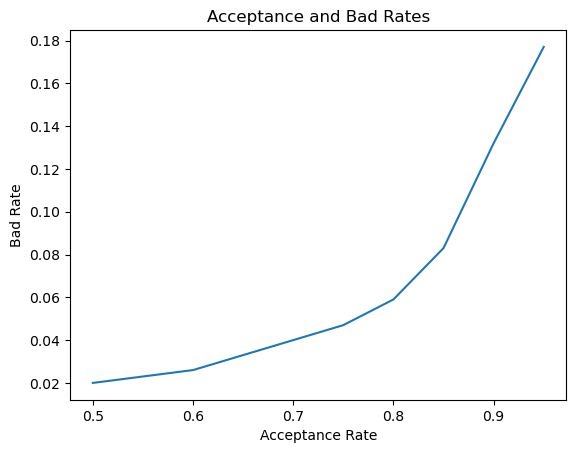

In [59]:
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.show()

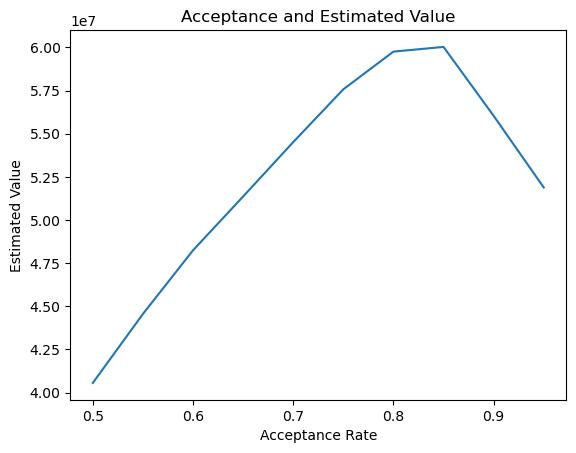

In [60]:
plt.plot(strat_df['Acceptance Rate'], strat_df['Estimated Value'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.title('Acceptance and Estimated Value')
plt.show()

When acceptance rate is equal to 0.85, we achived the highest value